# MED-PC Data Processing Notebook

## Importing the Python Libraries

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from medpc2excel.medpc_read import medpc_read

In [3]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

## Inputting the MED-PC log file

- **Please make sure that the corresponding `.mpc` file (aka the MED-PC script) that was ran to create the log file, is also in the same folder**

In [4]:
# The path to the MED-PC log file. It can be a relative path(based on current directory of notebook) or absolute
data_file = "./data/2022-05-04_13h06m_Subject 4.4 (4).txt"

In [5]:
# Reading in the MED-PC log file
ts_df, log = medpc_read(data_file, override = True, replace = False)

- To check what the available date keys are. Copy the column name (i.e. 20220503) into the cell after the next one

In [6]:
pd.DataFrame.from_dict(ts_df)

,20220504
4.4 (4),(P)Portentry (Q)USdelivery (R)UStime ...


In [7]:
# Copy the key into these paranthesis
date_key = "20220504"

In [8]:
# Getting the Dataframe that was created from the medpc2excel library
for key, value in ts_df[date_key].items():
    med_pc_df = value
    break 

In [9]:
med_pc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity
0,1.65,64.0,399.0,0.0,60.01,1.72,1.0,0.0
1,2.12,144.0,399.0,0.0,140.01,3.17,1.0,0.0
2,3.24,234.0,399.0,0.0,230.01,3.36,1.0,0.0
3,4.62,314.0,399.0,0.0,310.01,4.76,1.0,0.0
4,28.22,389.0,399.0,0.0,385.01,30.37,1.0,0.0


In [10]:
med_pc_df.columns

Index(['(P)Portentry', '(Q)USdelivery', '(R)UStime', '(W)ITIvalues',
       '(S)CSpresentation', '(N)Portexit', '(K)CStype', '(B)shockintensity'],
      dtype='object')

- Getting the names of every column and creating a dictionary for easier retrival

In [11]:
attribute_to_column_name = {}
for column in med_pc_df.columns:
    column_stripped = column.split(")", 1)[1]
    attribute_to_column_name[column_stripped] = column

In [12]:
attribute_to_column_name

{'Portentry': '(P)Portentry',
 'USdelivery': '(Q)USdelivery',
 'UStime': '(R)UStime',
 'ITIvalues': '(W)ITIvalues',
 'CSpresentation': '(S)CSpresentation',
 'Portexit': '(N)Portexit',
 'CStype': '(K)CStype',
 'shockintensity': '(B)shockintensity'}

- Use these variables when you need to reference the column

In [13]:
port_entry_column = attribute_to_column_name["Portentry"]
port_exit_column = attribute_to_column_name["Portexit"]
tone_start_column = attribute_to_column_name["CSpresentation"]

In [14]:
port_entry_column

'(P)Portentry'

In [15]:
med_pc_df[port_entry_column].head()

0     1.65
1     2.12
2     3.24
3     4.62
4    28.22
Name: (P)Portentry, dtype: float64

- Dropping all the NaN Rows

In [16]:
med_pc_df = med_pc_df.dropna(subset=(port_entry_column, port_exit_column))

In [17]:
med_pc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity
0,1.65,64.0,399.0,0.0,60.01,1.72,1.0,0.0
1,2.12,144.0,399.0,0.0,140.01,3.17,1.0,0.0
2,3.24,234.0,399.0,0.0,230.01,3.36,1.0,0.0
3,4.62,314.0,399.0,0.0,310.01,4.76,1.0,0.0
4,28.22,389.0,399.0,0.0,385.01,30.37,1.0,0.0


In [18]:
med_pc_df.tail()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity
481,3700.96,NaN,NaN,0.0,NaN,3700.98,0.0,0.0
482,3701.52,NaN,NaN,0.0,NaN,3701.54,0.0,0.0
483,3701.56,NaN,NaN,0.0,NaN,3701.65,0.0,0.0
484,3720.49,NaN,NaN,0.0,NaN,3728.91,0.0,0.0
485,3731.57,NaN,NaN,0.0,NaN,3732.15,0.0,0.0


## Simple Calculations

- Getting the duration of the time that the mice was in the port

In [19]:
med_pc_df[port_exit_column] - med_pc_df[port_entry_column]

0      0.07
1      1.05
2      0.12
3      0.14
4      2.15
       ... 
481    0.02
482    0.02
483    0.09
484    8.42
485    0.58
Length: 486, dtype: float64

# 1. Latency to port from tone onset

In [20]:
med_pc_df.iloc[0]

(P)Portentry           1.65
(Q)USdelivery         64.00
(R)UStime            399.00
(W)ITIvalues           0.00
(S)CSpresentation     60.01
(N)Portexit            1.72
(K)CStype              1.00
(B)shockintensity      0.00
Name: 0, dtype: float64

- Finding the first port entry after tone plays
    - ** NOTE: This does not count entries that started before the tone and continure after the tone started

# TODO: Make it so that if the mice are already in the port, then set the latency to zero

In [21]:
counter = 0
# Creating a dictionary of index(current row number we're on) to current/next tone time and first port entry
latency_dict = defaultdict(dict)
for index, row in med_pc_df.iterrows():
    # Using a counter so that we don't go through all the rows that include NaNs
    if counter >= 40:
        break
    try:
        # The time of the current tone that we're on
        current_tone_time = row[tone_start_column]
        latency_dict[index]["current_tone_time"] = current_tone_time
        # The time of the next tone after the current tone
        next_tone_time = med_pc_df.iloc[index + 1][tone_start_column]
        latency_dict[index]["next_tone_time"] = next_tone_time
        # Getting all the port entries that happened after the tone started
        # And then getting the first one of those port entries
        first_port_entry_after_tone = med_pc_df[med_pc_df[port_entry_column] >= current_tone_time][port_entry_column].min()
        latency_dict[index]["first_port_entry_after_tone"] = first_port_entry_after_tone
    except:
        break
    counter += 1

In [22]:
latency_dict[0]

{'current_tone_time': 60.01,
 'next_tone_time': 140.01,
 'first_port_entry_after_tone': 62.96}

- Creating a dataframe from the dictionary

In [23]:
latency_df = pd.DataFrame.from_dict(latency_dict, orient="index")

- Calculating latency, which is the first port entry time minus the start of the tone

In [24]:
latency_df["latency"] = latency_df["first_port_entry_after_tone"] - latency_df["current_tone_time"]

In [25]:
# Filtering for all the latencies that are less than 30 seconds
latency_df[latency_df["latency"] <= 30]

,current_tone_time,next_tone_time,first_port_entry_after_tone,latency
0,60.01,140.01,62.96,2.95
1,140.01,230.01,151.59,11.58
2,230.01,310.01,231.74,1.73
3,310.01,385.01,320.61,10.60
4,385.01,485.01,385.29,0.28
5,485.01,580.01,494.06,9.05
6,580.01,670.01,587.03,7.02
7,670.01,750.01,678.56,8.55
8,750.01,840.01,750.79,0.78
9,840.01,940.01,847.89,7.88


In [26]:
latency_df["latency"].mean()

11.67324999999989

# 2. Ratio of adequate retrival

- Calculating the ratio of adequate retrivals. Which are retrivals with latencies of less than 10 seconds

In [27]:
# Counting the number of retrivals that are less than 10 seconds
# Getting the total number of tones being played
sum(latency_df["latency"] <= 10) / len(latency_df)

0.55

# 3. Plotting the probability of inside port

- Plotting the duration that the mice are in the ports and the duration of the tones
    - Top is port entry duration and bottom is tone duration

# TODO: Try plotting so that whenever there's a port entry or tone, the line goes to 1

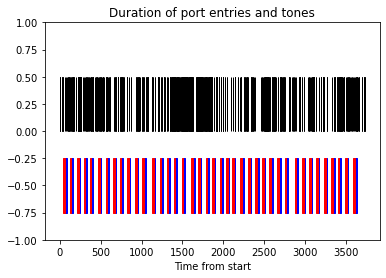

In [28]:
fig, ax = plt.subplots()

# Port duration is from one port entry to the corresponding por exit
for x_1 , x_2 in zip(med_pc_df['(P)Portentry'].values ,med_pc_df['(N)Portexit'].values):
    ax.add_patch(plt.Rectangle((x_1,0),x_2-x_1,0.5, color="k"))

# Tone duration is from tone start to 20 seconds after
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1,-.75),20,0.5, color="b"))
    
# Tone duration is from 20 seconds before to tone start
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1-20,-.75),20,0.5, color="r") )
    
ax.autoscale()
ax.set_ylim(-1,1)
plt.title("Duration of port entries and tones")
plt.xlabel("Time from start")
plt.show()

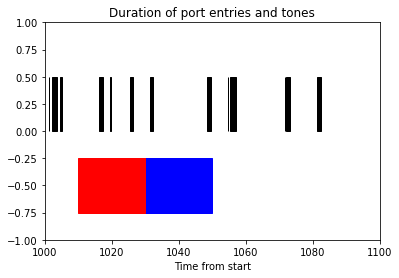

In [29]:
fig, ax = plt.subplots()

# Port duration is from one port entry to the corresponding por exit
for x_1 , x_2 in zip(med_pc_df['(P)Portentry'].values ,med_pc_df['(N)Portexit'].values):
    ax.add_patch(plt.Rectangle((x_1,0),x_2-x_1,0.5, color="k"))

# Tone duration is from tone start to 20 seconds after
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1,-.75),20,0.5, color="b"))
    
# Tone duration is from 20 seconds before to tone start
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1-20,-.75),20,0.5, color="r") )
    
ax.autoscale()
ax.set_ylim(-1,1)
ax.set_xlim(1000,1100)
plt.title("Duration of port entries and tones")
plt.xlabel("Time from start")
plt.show()

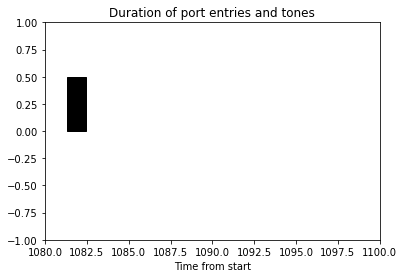

In [30]:
fig, ax = plt.subplots()

# Port duration is from one port entry to the corresponding por exit
for x_1 , x_2 in zip(med_pc_df['(P)Portentry'].values ,med_pc_df['(N)Portexit'].values):
    ax.add_patch(plt.Rectangle((x_1,0),x_2-x_1,0.5, color="k"))

# Tone duration is from tone start to 20 seconds after
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1,-.75),20,0.5, color="b"))
    
# Tone duration is from 20 seconds before to tone start
for x_1 in (latency_df['current_tone_time'].values):
    ax.add_patch(plt.Rectangle((x_1-20,-.75),20,0.5, color="r") )
    
ax.autoscale()
ax.set_ylim(-1,1)
ax.set_xlim(1080,1100)
plt.title("Duration of port entries and tones")
plt.xlabel("Time from start")
plt.show()

In [31]:
med_pc_df.iloc[130:150]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity
130,768.89,NaN,NaN,0.0,NaN,769.58,0.0,0.0
131,774.40,NaN,NaN,0.0,NaN,775.32,0.0,0.0
132,787.44,NaN,NaN,0.0,NaN,787.50,0.0,0.0
133,788.04,NaN,NaN,0.0,NaN,788.66,0.0,0.0
134,818.93,NaN,NaN,0.0,NaN,819.02,0.0,0.0
135,819.09,NaN,NaN,0.0,NaN,820.16,0.0,0.0
136,820.53,NaN,NaN,0.0,NaN,820.63,0.0,0.0
137,823.23,NaN,NaN,0.0,NaN,824.36,0.0,0.0
138,825.29,NaN,NaN,0.0,NaN,825.33,0.0,0.0
139,847.89,NaN,NaN,0.0,NaN,849.60,0.0,0.0


### 3.1 Scaling all the times so that we can get all the numbers in between

In [32]:
med_pc_df["port_entry_scaled"] = (med_pc_df[port_entry_column] * 100).astype(int)
med_pc_df["port_exit_scaled"] = (med_pc_df[port_exit_column] * 100).astype(int)
med_pc_df["tone_start_scaled"] = med_pc_df[tone_start_column].apply(lambda x: x * 100 if not np.isnan(x) else np.nan)

/tmp/ipykernel_359520/937648207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_pc_df["port_entry_scaled"] = (med_pc_df[port_entry_column] * 100).astype(int)
/tmp/ipykernel_359520/937648207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_pc_df["port_exit_scaled"] = (med_pc_df[port_exit_column] * 100).astype(int)
/tmp/ipykernel_359520/937648207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [33]:
med_pc_df.head(n=25)

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,port_entry_scaled,port_exit_scaled,tone_start_scaled
0,1.65,64.0,399.0,0.0,60.01,1.72,1.0,0.0,165,172,6001.0
1,2.12,144.0,399.0,0.0,140.01,3.17,1.0,0.0,212,317,14001.0
2,3.24,234.0,399.0,0.0,230.01,3.36,1.0,0.0,324,336,23001.0
3,4.62,314.0,399.0,0.0,310.01,4.76,1.0,0.0,462,476,31001.0
4,28.22,389.0,399.0,0.0,385.01,30.37,1.0,0.0,2822,3037,38501.0
5,62.96,489.0,399.0,0.0,485.01,64.18,1.0,0.0,6296,6418,48501.0
6,69.70,584.0,399.0,0.0,580.01,69.85,1.0,0.0,6970,6984,58001.0
7,88.76,674.0,399.0,0.0,670.01,88.92,1.0,0.0,8876,8892,67001.0
8,101.46,754.0,399.0,0.0,750.01,104.41,1.0,0.0,10146,10441,75001.0
9,104.43,844.0,399.0,0.0,840.01,104.69,1.0,0.0,10443,10469,84001.0


### 3.2 Getting the numbers that overlap between a single tone duration and port entry

In [34]:
def get_overlapping_range(tone_start, tone_end, port_entry, port_exit):
    """
    """
    if tone_start >= tone_end or port_entry >= port_exit:
        raise ValueError("Start time needs to be before end time")
    # Port exit is before tone_start
    if port_exit <= tone_start:
        return 0,0
    # Port entry is after tone end
    elif port_entry >= tone_end:
        return 0,0
    # Port entry is before tone start
    if port_entry <= tone_start:
        port_entry = tone_start
    # Port exit is after tone end
    if port_exit >= tone_end:
        port_exit = tone_end
    return port_entry, port_exit

- When there is no overlap before or after the tone

In [35]:
get_overlapping_range(port_entry=2960, port_exit=3038, tone_start=6001, tone_end=7001)

(0, 0)

In [36]:
get_overlapping_range(port_entry=15467, port_exit=15472, tone_start=6001, tone_end=7001)

(0, 0)

- When there is all overlap within the tone

In [37]:
get_overlapping_range(port_entry=6131, port_exit=6177, tone_start=6001, tone_end=7001)

(6131, 6177)

- When there is partial overlap with the tone

In [38]:
get_overlapping_range(port_entry=5900, port_exit=6177, tone_start=6001, tone_end=7001)

(6001, 6177)

In [39]:
get_overlapping_range(port_entry=6800, port_exit=7200, tone_start=6001, tone_end=7001)

(6800, 7001)

## 3.2 Getting all the overlapping port entries time stamps with the tone durations

### Getting the times in between all the port entries and exits

In [40]:
port_entry_times = med_pc_df["port_entry_scaled"].values
port_exit_times = med_pc_df["port_exit_scaled"].values

- Making a 2D array of the port entry and exit times

In [41]:
np.column_stack((port_entry_times, port_exit_times))[:10]

array([[  165,   172],
       [  212,   317],
       [  324,   336],
       [  462,   476],
       [ 2822,  3037],
       [ 6296,  6418],
       [ 6970,  6984],
       [ 8876,  8892],
       [10146, 10441],
       [10443, 10469]])

In [42]:
def get_all_numbers_in_range(before_array, after_array):
    """
    """
    all_ranges = None
    for first_number, second_number in np.column_stack((before_array, after_array)):
        current_range = np.arange(first_number, second_number)
        if all_ranges is None:
            all_ranges = current_range
        else:
            all_ranges = np.concatenate((all_ranges, current_range))
    return all_ranges

In [43]:
masked_range = get_all_numbers_in_range(port_entry_times, port_exit_times)

In [44]:
masked_range[:100]

array([165, 166, 167, 168, 169, 170, 171, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304])

## 3.3 Getting the ratio of the overlap

In [45]:
def get_overlapping_ratio(tone_start, tone_end, port_entry, port_exit):
    """
    """
    overlapping_range = get_overlapping_range(tone_start=tone_start, tone_end=tone_end, \
                                              port_entry=port_entry, port_exit=port_exit)
    return (overlapping_range[1] - overlapping_range[0]) / (tone_end - tone_start)

- When there is no overlap before or after the tone

In [46]:
get_overlapping_ratio(port_entry=2960, port_exit=3038, tone_start=6001, tone_end=7001)

0.0

In [47]:
get_overlapping_ratio(port_entry=15467, port_exit=15472, tone_start=6001, tone_end=7001)

0.0

- When there is all overlap within the tone

In [48]:
get_overlapping_ratio(port_entry=6131, port_exit=6177, tone_start=6001, tone_end=7001)

0.046

- When there is partial overlap with the tone

In [49]:
get_overlapping_ratio(port_entry=5900, port_exit=6177, tone_start=6001, tone_end=7001)

0.176

In [50]:
get_overlapping_ratio(port_entry=6800, port_exit=7200, tone_start=6001, tone_end=7001)

0.201

- When there is total overlap of the tone

In [51]:
get_overlapping_ratio(port_entry=5500, port_exit=7500, tone_start=6001, tone_end=7001)

1.0

### 3.4 Get all the overlapping ranges for one tone 

- The port entry must always be before the end of the tone
- The port exit must always be after the start of the tone

In [52]:
med_pc_df.head(n=10)

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,port_entry_scaled,port_exit_scaled,tone_start_scaled
0,1.65,64.0,399.0,0.0,60.01,1.72,1.0,0.0,165,172,6001.0
1,2.12,144.0,399.0,0.0,140.01,3.17,1.0,0.0,212,317,14001.0
2,3.24,234.0,399.0,0.0,230.01,3.36,1.0,0.0,324,336,23001.0
3,4.62,314.0,399.0,0.0,310.01,4.76,1.0,0.0,462,476,31001.0
4,28.22,389.0,399.0,0.0,385.01,30.37,1.0,0.0,2822,3037,38501.0
5,62.96,489.0,399.0,0.0,485.01,64.18,1.0,0.0,6296,6418,48501.0
6,69.70,584.0,399.0,0.0,580.01,69.85,1.0,0.0,6970,6984,58001.0
7,88.76,674.0,399.0,0.0,670.01,88.92,1.0,0.0,8876,8892,67001.0
8,101.46,754.0,399.0,0.0,750.01,104.41,1.0,0.0,10146,10441,75001.0
9,104.43,844.0,399.0,0.0,840.01,104.69,1.0,0.0,10443,10469,84001.0


In [53]:
def get_all_overlapping_ranges(tone_start, tone_end, med_pc_df, port_entry_column='(P)Portentry', port_exit_column='(N)Portexit'):
    """
    """
    return med_pc_df[(med_pc_df[port_exit_column] >= tone_start) & (med_pc_df[port_entry_column] <= tone_end)]

In [54]:
tone_start = 60
tone_end = 90

In [55]:
overlapped_df = get_all_overlapping_ranges(tone_start=tone_start, tone_end=tone_end, med_pc_df=med_pc_df)

In [56]:
overlapped_df

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,port_entry_scaled,port_exit_scaled,tone_start_scaled
5,62.96,489.0,399.0,0.0,485.01,64.18,1.0,0.0,6296,6418,48501.0
6,69.70,584.0,399.0,0.0,580.01,69.85,1.0,0.0,6970,6984,58001.0
7,88.76,674.0,399.0,0.0,670.01,88.92,1.0,0.0,8876,8892,67001.0


### 3.5 Get the sum of the overlap ratio for all overlapping port entries 

In [57]:
def calculate_total_overlap_ratio(med_pc_df, tone_start, tone_end, port_entry_column='(P)Portentry', port_exit_column='(N)Portexit'):
    """
    """
    all_overlap_ratios = []
    overlapped_df = get_all_overlapping_ranges(tone_start=tone_start, tone_end=tone_end, med_pc_df=med_pc_df, port_entry_column=port_entry_column, port_exit_column=port_exit_column)
    
    for index, row in overlapped_df.iterrows():
        overlap_ratio = get_overlapping_ratio(port_entry=row[port_entry_column], port_exit=row[port_exit_column], tone_start=tone_start, tone_end=tone_end)
        all_overlap_ratios.append(overlap_ratio)
    return sum(all_overlap_ratios)

In [58]:
calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=60, tone_end=90)

0.050999999999999795

### 3.6 Plot overlap ratios for one trial

In [59]:
tone_start = 60

- Getting the time sub-time intervals for each tone duration
    - We will look into the time 20 seconds before and after the tone starts

- For the sub time intervals that are one second

In [60]:
evenly_spaced_ones_intervals = np.linspace(0 - 20, 0 + 20, 41)

In [61]:
evenly_spaced_ones_intervals

array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

In [62]:
evenly_spaced_ones_numbers = evenly_spaced_ones_intervals + 60

In [63]:
evenly_spaced_ones_numbers

array([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80.])

In [64]:
evenly_spaced_ones_numbers + 60

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140.])

- For the sub time intervals that are one tenth of a second

In [65]:
evenly_spaced_tenths_intervals = np.linspace(0 - 20, 0 + 20, 401)

In [66]:
evenly_spaced_tenths_numbers = evenly_spaced_tenths_intervals + 60

In [67]:
evenly_spaced_tenths_numbers

array([40. , 40.1, 40.2, 40.3, 40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41. ,
       41.1, 41.2, 41.3, 41.4, 41.5, 41.6, 41.7, 41.8, 41.9, 42. , 42.1,
       42.2, 42.3, 42.4, 42.5, 42.6, 42.7, 42.8, 42.9, 43. , 43.1, 43.2,
       43.3, 43.4, 43.5, 43.6, 43.7, 43.8, 43.9, 44. , 44.1, 44.2, 44.3,
       44.4, 44.5, 44.6, 44.7, 44.8, 44.9, 45. , 45.1, 45.2, 45.3, 45.4,
       45.5, 45.6, 45.7, 45.8, 45.9, 46. , 46.1, 46.2, 46.3, 46.4, 46.5,
       46.6, 46.7, 46.8, 46.9, 47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6,
       47.7, 47.8, 47.9, 48. , 48.1, 48.2, 48.3, 48.4, 48.5, 48.6, 48.7,
       48.8, 48.9, 49. , 49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8,
       49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9,
       51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. ,
       52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9, 53. , 53.1,
       53.2, 53.3, 53.4, 53.5, 53.6, 53.7, 53.8, 53.9, 54. , 54.1, 54.2,
       54.3, 54.4, 54.5, 54.6, 54.7, 54.8, 54.9, 55

### 3.61 Getting all the overlap ratios for the tone that starts at 60 seconds

In [68]:
med_pc_df.head(n=25)

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,port_entry_scaled,port_exit_scaled,tone_start_scaled
0,1.65,64.0,399.0,0.0,60.01,1.72,1.0,0.0,165,172,6001.0
1,2.12,144.0,399.0,0.0,140.01,3.17,1.0,0.0,212,317,14001.0
2,3.24,234.0,399.0,0.0,230.01,3.36,1.0,0.0,324,336,23001.0
3,4.62,314.0,399.0,0.0,310.01,4.76,1.0,0.0,462,476,31001.0
4,28.22,389.0,399.0,0.0,385.01,30.37,1.0,0.0,2822,3037,38501.0
5,62.96,489.0,399.0,0.0,485.01,64.18,1.0,0.0,6296,6418,48501.0
6,69.70,584.0,399.0,0.0,580.01,69.85,1.0,0.0,6970,6984,58001.0
7,88.76,674.0,399.0,0.0,670.01,88.92,1.0,0.0,8876,8892,67001.0
8,101.46,754.0,399.0,0.0,750.01,104.41,1.0,0.0,10146,10441,75001.0
9,104.43,844.0,399.0,0.0,840.01,104.69,1.0,0.0,10443,10469,84001.0


In [69]:
tone_start_time = 60

- For one second intervals

In [70]:
calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=47, tone_end=48)

0

In [71]:
tone_ratio_ones_dict = defaultdict(dict)
for index, tone_start_ones in enumerate(evenly_spaced_ones_intervals):
    actual_start_time = tone_start_ones + tone_start_time
    actual_end_time = actual_start_time + 1
    tone_ratio_ones_dict[actual_start_time]["tone_start_ones"] = tone_start_ones 
    overlap_ratio = calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=actual_start_time, tone_end=actual_end_time)
    tone_ratio_ones_dict[actual_start_time]["overlap_ratio"] = overlap_ratio


In [72]:
tone_ratio_ones_dict

defaultdict(dict,
            {40.0: {'tone_start_ones': -20.0, 'overlap_ratio': 0},
             41.0: {'tone_start_ones': -19.0, 'overlap_ratio': 0},
             42.0: {'tone_start_ones': -18.0, 'overlap_ratio': 0},
             43.0: {'tone_start_ones': -17.0, 'overlap_ratio': 0},
             44.0: {'tone_start_ones': -16.0, 'overlap_ratio': 0},
             45.0: {'tone_start_ones': -15.0, 'overlap_ratio': 0},
             46.0: {'tone_start_ones': -14.0, 'overlap_ratio': 0},
             47.0: {'tone_start_ones': -13.0, 'overlap_ratio': 0},
             48.0: {'tone_start_ones': -12.0, 'overlap_ratio': 0},
             49.0: {'tone_start_ones': -11.0, 'overlap_ratio': 0},
             50.0: {'tone_start_ones': -10.0, 'overlap_ratio': 0},
             51.0: {'tone_start_ones': -9.0, 'overlap_ratio': 0},
             52.0: {'tone_start_ones': -8.0, 'overlap_ratio': 0},
             53.0: {'tone_start_ones': -7.0, 'overlap_ratio': 0},
             54.0: {'tone_start_ones': -6.0, 'o

- For one tenth of second intervals

In [73]:
tone_ratio_tenths_dict = defaultdict(dict)
for index, tone_start_tenths in enumerate(evenly_spaced_tenths_intervals):
    actual_start_time = tone_start_tenths + tone_start_time
    actual_end_time = actual_start_time + 0.1
    tone_ratio_tenths_dict[actual_start_time]["tone_start_ones"] = tone_start_tenths 
    overlap_ratio = calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=actual_start_time, tone_end=actual_end_time)
    tone_ratio_tenths_dict[actual_start_time]["overlap_ratio"] = overlap_ratio


In [74]:
tone_ratio_tenths_dict

defaultdict(dict,
            {40.0: {'tone_start_ones': -20.0, 'overlap_ratio': 0},
             40.1: {'tone_start_ones': -19.9, 'overlap_ratio': 0},
             40.2: {'tone_start_ones': -19.8, 'overlap_ratio': 0},
             40.3: {'tone_start_ones': -19.7, 'overlap_ratio': 0},
             40.4: {'tone_start_ones': -19.6, 'overlap_ratio': 0},
             40.5: {'tone_start_ones': -19.5, 'overlap_ratio': 0},
             40.6: {'tone_start_ones': -19.4, 'overlap_ratio': 0},
             40.7: {'tone_start_ones': -19.3, 'overlap_ratio': 0},
             40.8: {'tone_start_ones': -19.2, 'overlap_ratio': 0},
             40.9: {'tone_start_ones': -19.1, 'overlap_ratio': 0},
             41.0: {'tone_start_ones': -19.0, 'overlap_ratio': 0},
             41.1: {'tone_start_ones': -18.9, 'overlap_ratio': 0},
             41.2: {'tone_start_ones': -18.8, 'overlap_ratio': 0},
             41.3: {'tone_start_ones': -18.7, 'overlap_ratio': 0},
             41.4: {'tone_start_ones': -18.6

In [75]:
overlap_interval_ones_df = pd.DataFrame.from_dict(tone_ratio_ones_dict, orient="index")
overlap_interval_tenths_df = pd.DataFrame.from_dict(tone_ratio_tenths_dict, orient="index")

In [76]:
overlap_interval_ones_df.head()

,tone_start_ones,overlap_ratio
40.0,-20.0,0.0
41.0,-19.0,0.0
42.0,-18.0,0.0
43.0,-17.0,0.0
44.0,-16.0,0.0


In [77]:
overlap_interval_tenths_df.head(n=50)

,tone_start_ones,overlap_ratio
40.0,-20.0,0.0
40.1,-19.9,0.0
40.2,-19.8,0.0
40.3,-19.7,0.0
40.4,-19.6,0.0
40.5,-19.5,0.0
40.6,-19.4,0.0
40.7,-19.3,0.0
40.8,-19.2,0.0
40.9,-19.1,0.0


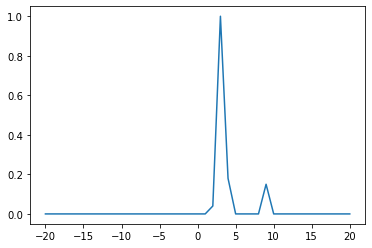

In [78]:
plt.plot(overlap_interval_ones_df["tone_start_ones"], overlap_interval_ones_df["overlap_ratio"])

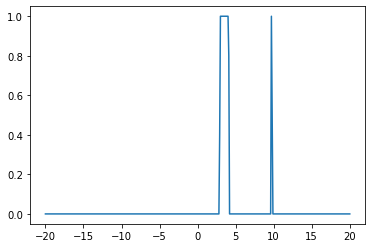

In [79]:
plt.plot(overlap_interval_tenths_df["tone_start_ones"], overlap_interval_tenths_df["overlap_ratio"])

# 3.7 Plot all the tones and average them

In [80]:
# Using head because after 40 all the values just become random place holders
tone_start_times = med_pc_df[tone_start_column].dropna().head(39)

In [81]:
tone_start_times

0       60.01
1      140.01
2      230.01
3      310.01
4      385.01
5      485.01
6      580.01
7      670.01
8      750.01
9      840.01
10     940.01
11    1030.01
12    1150.01
13    1240.01
14    1325.01
15    1415.01
16    1510.01
17    1630.01
18    1710.01
19    1805.01
20    1885.01
21    1975.01
22    2055.01
23    2130.01
24    2230.01
25    2325.01
26    2415.01
27    2495.01
28    2585.01
29    2685.01
30    2775.01
31    2895.01
32    2985.01
33    3070.01
34    3160.01
35    3255.01
36    3345.01
37    3425.01
38    3515.01
Name: (S)CSpresentation, dtype: float64

- For second intervals

In [82]:
all_tone_ratio_seconds_list = []
for tone_start_time in tone_start_times:
    tone_ratio_dict = defaultdict(dict)
    for index, tone_start_ones in enumerate(evenly_spaced_ones_intervals):
        actual_time = tone_start_ones + tone_start_time
        tone_ratio_dict[actual_time]["tone_start_ones"] = tone_start_ones 
        overlap_ratio = calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=actual_time, tone_end=actual_time + 1)
        tone_ratio_dict[actual_time]["overlap_ratio"] = overlap_ratio
    all_tone_ratio_seconds_list.append(tone_ratio_dict)

In [83]:
combined_ones_dict = {k: v for d in all_tone_ratio_seconds_list for k, v in d.items()}

In [84]:
combined_ones_dataframe = pd.DataFrame.from_dict(combined_ones_dict, orient="index")

In [85]:
combined_ones_dataframe

,tone_start_ones,overlap_ratio
40.01,-20.0,0.0
41.01,-19.0,0.0
42.01,-18.0,0.0
43.01,-17.0,0.0
44.01,-16.0,0.0
...,...,...
3531.01,16.0,1.0
3532.01,17.0,1.0
3533.01,18.0,1.0
3534.01,19.0,1.0


In [86]:
ones_result = combined_ones_dataframe.groupby('tone_start_ones').mean()

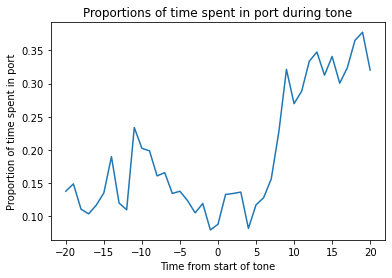

In [87]:
plt.plot(ones_result.index, ones_result["overlap_ratio"])
plt.title("Proportions of time spent in port during tone")
plt.xlabel("Time from start of tone")
plt.ylabel("Proportion of time spent in port")
plt.show()

- For one tenth of a second intervals 

In [88]:
all_tone_ratio_tenths_list = []
for tone_start_time in tone_start_times:
    tone_ratio_dict = defaultdict(dict)
    for index, tone_start_tenths in enumerate(evenly_spaced_tenths_intervals):
        actual_time = tone_start_tenths + tone_start_time
        tone_ratio_dict[actual_time]["tone_start_tenths"] = tone_start_tenths
        overlap_ratio = calculate_total_overlap_ratio(med_pc_df=med_pc_df, tone_start=actual_time, tone_end=actual_time + 0.1)
        tone_ratio_dict[actual_time]["overlap_ratio"] = overlap_ratio
    all_tone_ratio_tenths_list.append(tone_ratio_dict)

In [89]:
combined_tenths_dict = {k: v for d in all_tone_ratio_tenths_list for k, v in d.items()}

In [90]:
combined_tenths_dataframe = pd.DataFrame.from_dict(combined_tenths_dict, orient="index")

In [91]:
combined_tenths_dataframe

,tone_start_tenths,overlap_ratio
40.01,-20.0,0.0
40.11,-19.9,0.0
40.21,-19.8,0.0
40.31,-19.7,0.0
40.41,-19.6,0.0
...,...,...
3534.61,19.6,1.0
3534.71,19.7,1.0
3534.81,19.8,1.0
3534.91,19.9,1.0


In [92]:
tenths_result = combined_tenths_dataframe.groupby('tone_start_tenths').mean()

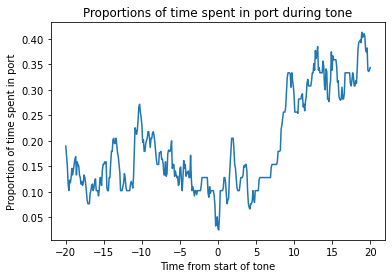

In [93]:
plt.plot(tenths_result.index, tenths_result["overlap_ratio"])
plt.title("Proportions of time spent in port during tone")
plt.xlabel("Time from start of tone")
plt.ylabel("Proportion of time spent in port")
plt.show()

# TODO: 4. Licking Specifity Average

average(probability(t=0-10)) -average(probability(t=-20:0))

# TODO: Get the average of each time second interval for the sessions